<a href="https://colab.research.google.com/github/rajvanshi08/Gym_form/blob/main/yolov5_alpr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv5 for Automatic License Plate Recognition

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Clone YOLOv5 code
!git clone https://github.com/rkuo2000/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 3390, done.
remote: Total 3390 (delta 0), reused 0 (delta 0), pack-reused 3390
Receiving objects: 100% (3390/3390), 7.02 MiB | 23.41 MiB/s, done.
Resolving deltas: 100% (2273/2273), done.
/content/yolov5


In [3]:
!echo "train: Dataset/train/images" > data/alpr.yaml
!echo "val:   Dataset/train/images" >> data/alpr.yaml

!echo "nc : 1" >> data/alpr.yaml
!echo "names: ['license_plate']" >> data/alpr.yaml

!cat data/alpr.yaml

train: Dataset/train/images
val:   Dataset/train/images
nc : 1
names: ['license_plate']


## Prepare Dataset

In [4]:
import os
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile

In [5]:
FILE_ROOT = "/content/drive/MyDrive/car_license_plate/"
IMAGE_PATH = FILE_ROOT + "images"  
ANNOTATIONS_PATH = FILE_ROOT + "annotations"

DATA_ROOT = "Dataset/"
DEST_IMAGES_PATH = "train/images"
DEST_LABELS_PATH = "train/labels"

In [6]:
!mkdir -p Dataset/train/labels

In [7]:
# copy images
!mkdir -p Dataset/train
!cp -rf /content/drive/MyDrive/car_license_plate/images/ Dataset/train

In [9]:
!mkdir -p Dataset/val
!cp -rf /content/drive/MyDrive/car_license_plate/images/Cars0.png Dataset/val

### Convert COCO Annotations to YOLOv5 Labels

In [10]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]
    
def save_file(img_jpg_file_name, size, img_box):
    classes = ['license_plate']
    save_file_name = DATA_ROOT + DEST_LABELS_PATH + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:                  
        #cls_num = classes.index(box[0]) # find class_id
        cls_num = 0
        new_box = cord_converter(size, box[1:]) # convert box coord into YOLO x,y,w,h

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)
    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [11]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

file name:  Cars105.xml
/content/drive/MyDrive/car_license_plate/annotations/Cars105.xml
box:(c,xmin,ymin,xmax,ymax) licence 152 147 206 159
Dataset/train/labels/Cars105.txt
file name:  Cars100.xml
/content/drive/MyDrive/car_license_plate/annotations/Cars100.xml
box:(c,xmin,ymin,xmax,ymax) licence 175 114 214 131
Dataset/train/labels/Cars100.txt
file name:  Cars101.xml
/content/drive/MyDrive/car_license_plate/annotations/Cars101.xml
box:(c,xmin,ymin,xmax,ymax) licence 167 202 240 220
Dataset/train/labels/Cars101.txt
file name:  Cars102.xml
/content/drive/MyDrive/car_license_plate/annotations/Cars102.xml
box:(c,xmin,ymin,xmax,ymax) licence 66 147 322 199
Dataset/train/labels/Cars102.txt
file name:  Cars108.xml
/content/drive/MyDrive/car_license_plate/annotations/Cars108.xml
box:(c,xmin,ymin,xmax,ymax) licence 158 216 277 248
Dataset/train/labels/Cars108.txt
file name:  Cars0.xml
/content/drive/MyDrive/car_license_plate/annotations/Cars0.xml
box:(c,xmin,ymin,xmax,ymax) licence 226 125 41

In [14]:
!mkdir -p Dataset/val/labels
!cp -rf /content/yolov5/Dataset/train/labels/Cars0.txt Dataset/val/labels

In [15]:
!ls Dataset/train/labels

cam10.txt    Cars108.txt  Cars185.txt  Cars261.txt  Cars338.txt  Cars414.txt
cam11.txt    Cars109.txt  Cars186.txt  Cars262.txt  Cars339.txt  Cars415.txt
cam12.txt    Cars10.txt   Cars187.txt  Cars263.txt  Cars33.txt	 Cars416.txt
cam13.txt    Cars110.txt  Cars188.txt  Cars264.txt  Cars340.txt  Cars417.txt
cam14.txt    Cars111.txt  Cars189.txt  Cars265.txt  Cars341.txt  Cars418.txt
cam15.txt    Cars112.txt  Cars18.txt   Cars266.txt  Cars342.txt  Cars419.txt
cam16.txt    Cars113.txt  Cars190.txt  Cars267.txt  Cars343.txt  Cars41.txt
cam17.txt    Cars114.txt  Cars191.txt  Cars268.txt  Cars344.txt  Cars420.txt
cam18.txt    Cars115.txt  Cars192.txt  Cars269.txt  Cars345.txt  Cars421.txt
cam19.txt    Cars116.txt  Cars193.txt  Cars26.txt   Cars346.txt  Cars422.txt
cam1.txt     Cars117.txt  Cars194.txt  Cars270.txt  Cars347.txt  Cars423.txt
cam20.txt    Cars118.txt  Cars195.txt  Cars271.txt  Cars348.txt  Cars424.txt
cam21.txt    Cars119.txt  Cars196.txt  Cars272.txt  Cars349.txt  Cars425.txt
c

## YOLOv5 Training

In [16]:
pip install -U PyYAML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 5.4 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [17]:
pip install torch==1.7.0+cu110 torchvision==0.8.1+cu110 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████▌        | 834.1 MB 1.2 MB/s eta 0:04:20tcmalloc: large alloc 1147494400 bytes == 0x3903c000 @  0x7f7870cf4615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▊  | 1055.7 MB 1.2 MB/s eta 0:01:07tcmalloc: large alloc 1434370048 bytes == 0x7d692000 @  0x7f7870cf4615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [18]:
!python train.py --img 416 --batch 16 --epochs 50 --data data/alpr.yaml --cfg models/yolov5s.yaml

Using torch 1.7.0+cu110 CUDA:0 (Tesla T4, 15109MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=False, cfg='models/yolov5s.yaml', data='data/alpr.yaml', device='', epochs=50, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False, save_dir='runs/train/exp', single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5s.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
NumExpr defaulting to 2 threads.
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0

## YOLOv5 Detect

In [19]:
# Download OpenALPR Benchmarks
%cd ..
!git clone https://github.com/openalpr/benchmarks

/content
Cloning into 'benchmarks'...
remote: Enumerating objects: 1752, done.
remote: Total 1752 (delta 0), reused 0 (delta 0), pack-reused 1752
Receiving objects: 100% (1752/1752), 187.98 MiB | 46.82 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [20]:
%cd yolov5/

/content/yolov5


In [22]:
!python detect.py --source ../benchmarks/endtoend/us --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='../benchmarks/endtoend/us', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
Using torch 1.7.0+cu110 CUDA:0 (Tesla T4, 15109MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients
image 1/222 /content/benchmarks/endtoend/us/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg: 384x640 1 license_plates, Done. (0.023s)
image 2/222 /content/benchmarks/endtoend/us/12c6cb72-3ea3-49e7-b381-e0cdfc5e8960.jpg: 384x640 Done. (0.014s)
image 3/222 /content/benchmarks/endtoend/us/1e241dc8-8f18-4955-8988-03a0ab49f813.jpg: 384x640 1 license_plates, Done. (0.014s)
image 4/222 /content/benchmarks/endtoend/us/21d8c31d-3deb-494b-9c63-c0223306fd82.jpg: 384x640 1 license_plates, Done. (0.015s)
image 5/222 /content/benchmarks/endtoend/us/22e54a62-57a8-4a0a-88c1-4b97

In [23]:
!python detect.py --source ../benchmarks/endtoend/eu --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='../benchmarks/endtoend/eu', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
Using torch 1.7.0+cu110 CUDA:0 (Tesla T4, 15109MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients
image 1/108 /content/benchmarks/endtoend/eu/eu1.jpg: 480x640 2 license_plates, Done. (0.024s)
image 2/108 /content/benchmarks/endtoend/eu/eu10.jpg: 544x640 2 license_plates, Done. (0.023s)
image 3/108 /content/benchmarks/endtoend/eu/eu11.jpg: 416x640 1 license_plates, Done. (0.024s)
image 4/108 /content/benchmarks/endtoend/eu/eu2.jpg: 480x640 1 license_plates, Done. (0.020s)
image 5/108 /content/benchmarks/endtoend/eu/eu3.jpg: 480x640 1 license_plates, Done. (0.016s)
image 6/108 /content/benchmarks/endtoend/eu/eu4.jpg: 416x640 Done. (0.015s)
image 7/108 /c

In [24]:
!python detect.py --source ../benchmarks/endtoend/br --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='../benchmarks/endtoend/br', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
Using torch 1.7.0+cu110 CUDA:0 (Tesla T4, 15109MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients
image 1/115 /content/benchmarks/endtoend/br/AYO9034.jpg: 384x640 1 license_plates, Done. (0.023s)
image 2/115 /content/benchmarks/endtoend/br/AZJ6991.jpg: 640x640 1 license_plates, Done. (0.014s)
image 3/115 /content/benchmarks/endtoend/br/FZB9581.jpg: 640x640 1 license_plates, Done. (0.014s)
image 4/115 /content/benchmarks/endtoend/br/GWT2180.jpg: 384x640 1 license_plates, Done. (0.014s)
image 5/115 /content/benchmarks/endtoend/br/HPM9362.jpg: 480x640 1 license_plates, Done. (0.022s)
image 6/115 /content/benchmarks/endtoend/br/JGZ3298.jpg: 480x640 1 licen

### Display Detected Images

In [25]:
from IPython.display import Image

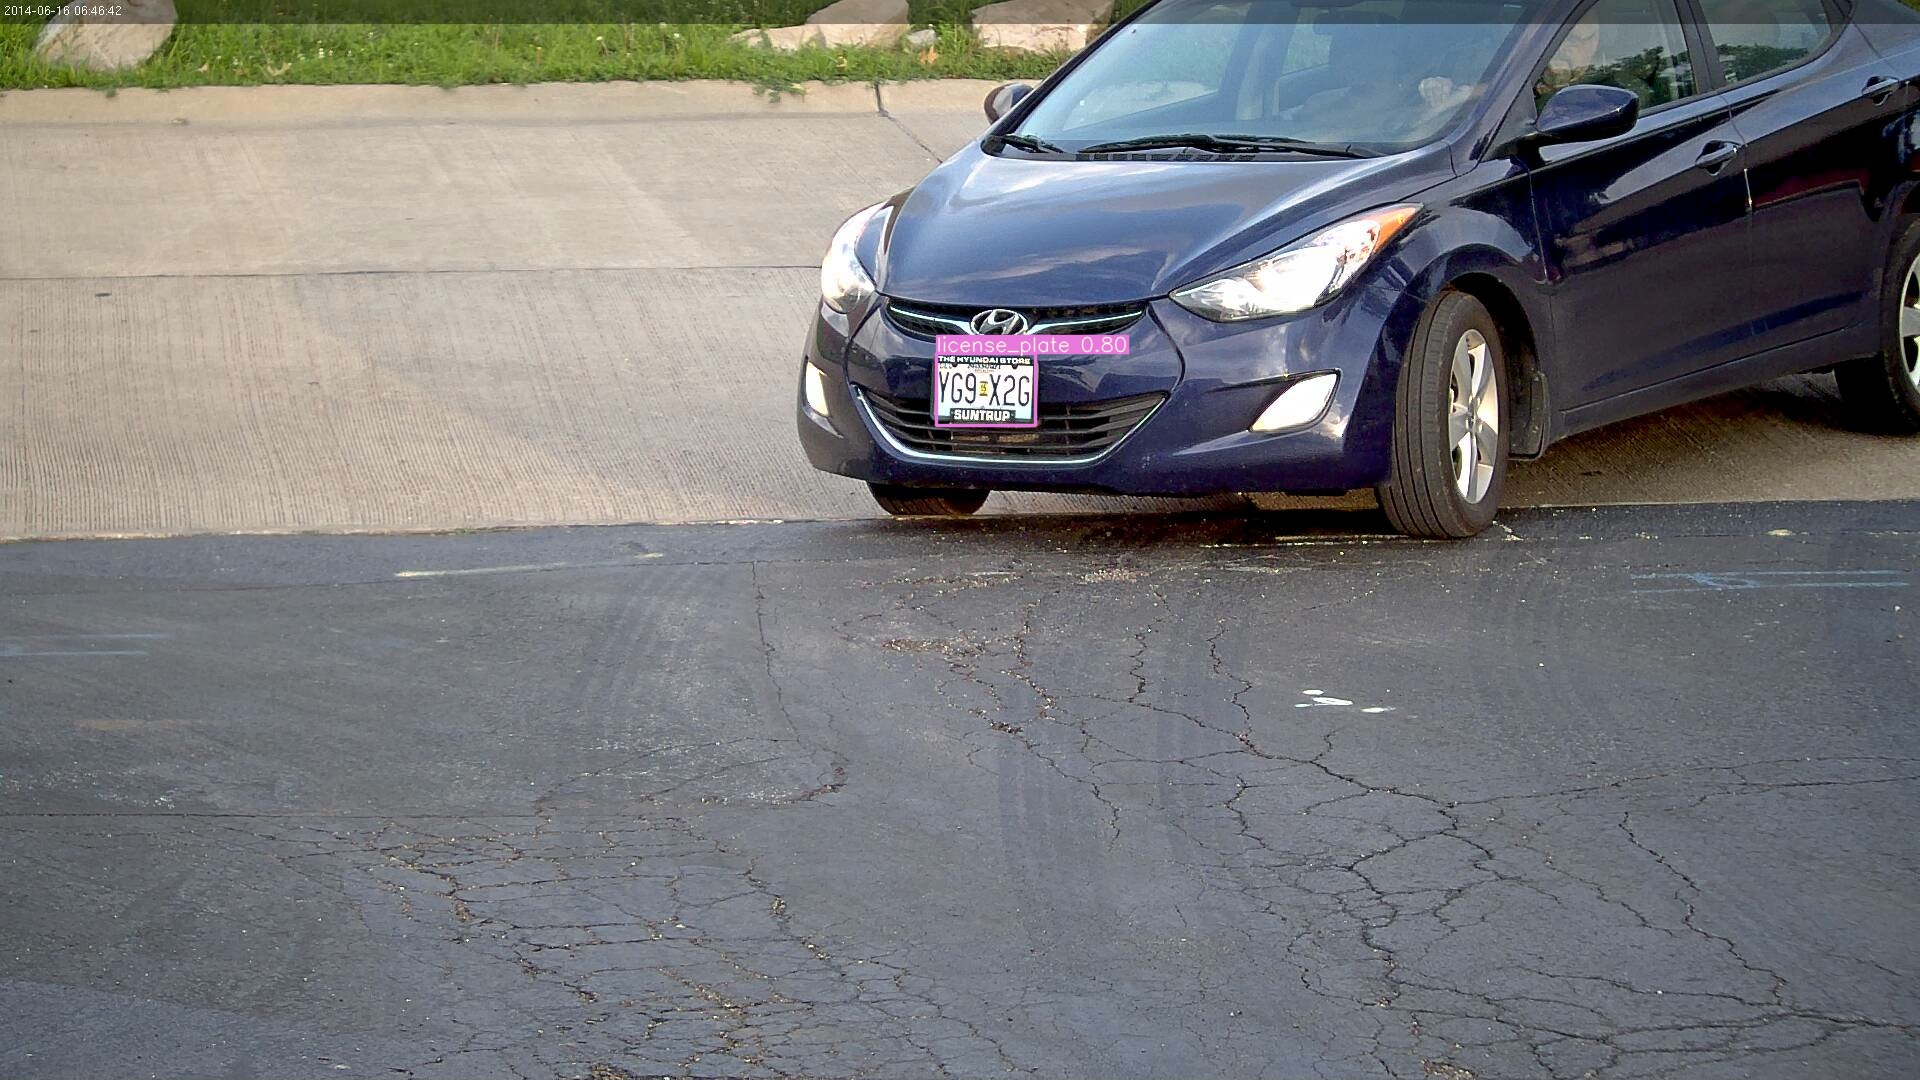

In [26]:
Image('runs/detect/exp/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg')

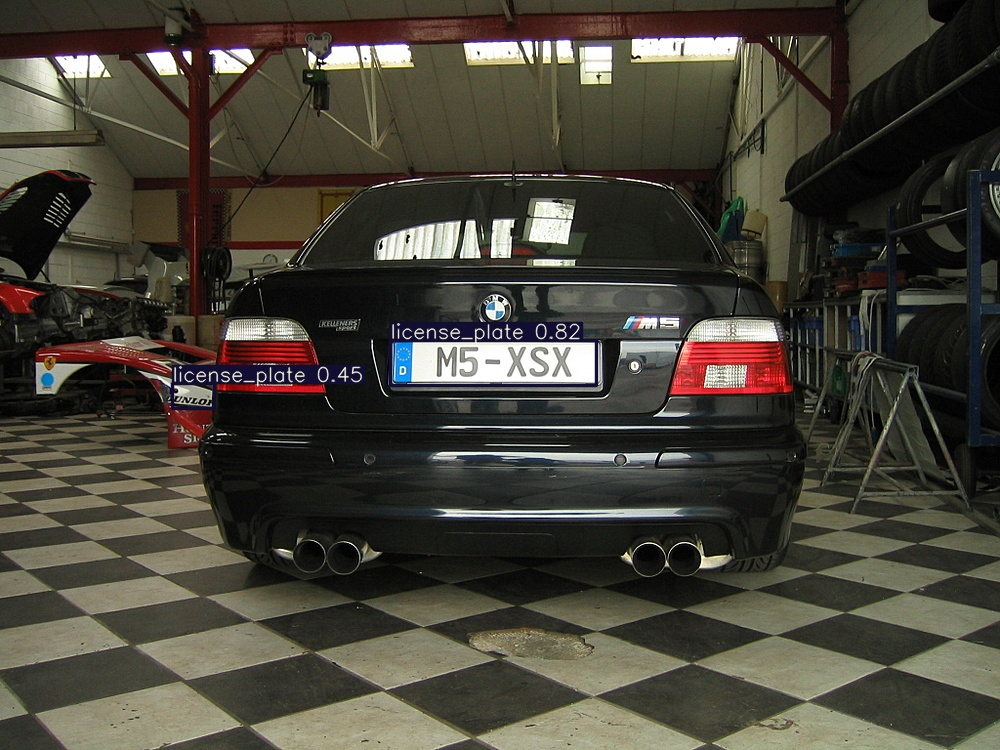

In [28]:
Image('/content/yolov5/runs/detect/exp3/eu1.jpg')

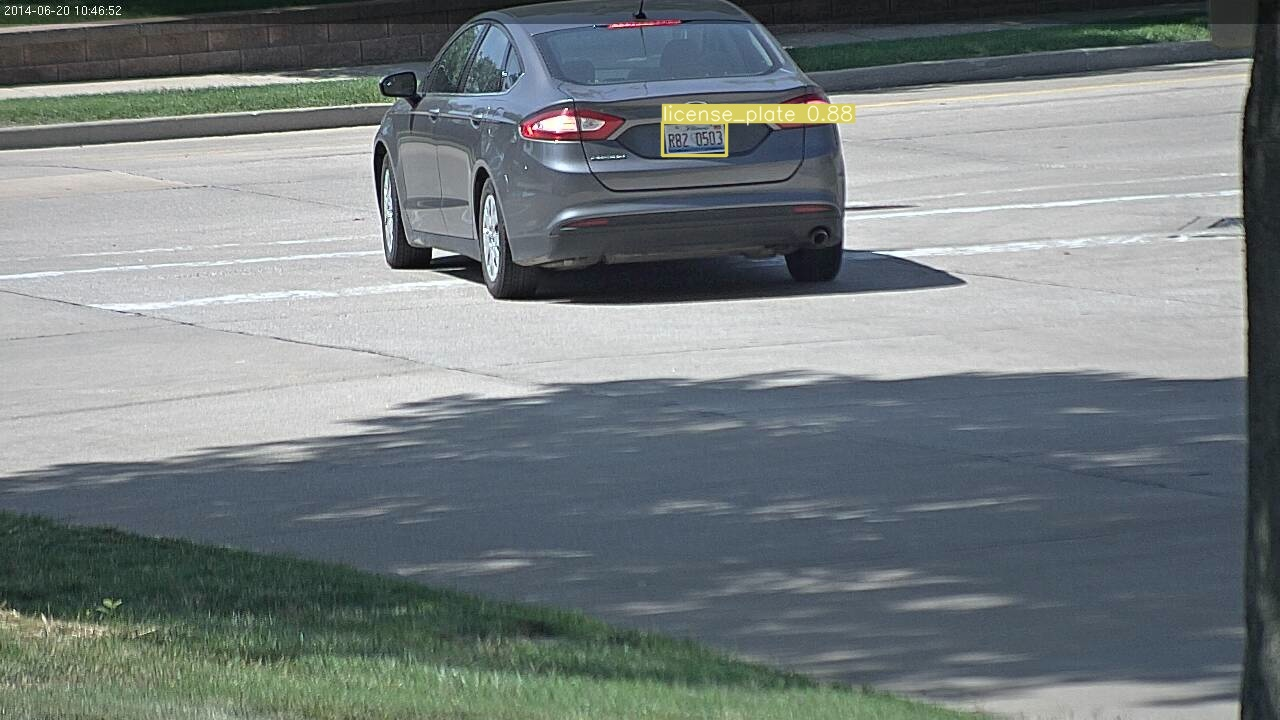

In [30]:
Image('/content/yolov5/runs/detect/exp2/33fa5185-0286-4e8f-b775-46162eba39d4.jpg')

## OCR 

### get detected ALPR bounding box

In [31]:
# list saved .txt
!ls runs/detect/exp/labels

0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.txt  car12.txt  car3.txt
1e241dc8-8f18-4955-8988-03a0ab49f813.txt  car13.txt  car5.txt
21d8c31d-3deb-494b-9c63-c0223306fd82.txt  car14.txt  car6.txt
22e54a62-57a8-4a0a-88c1-4b9758f67651.txt  car15.txt  car7.txt
316b64c0-55bf-4079-a1c0-d93f461a576f.txt  car16.txt  car8.txt
33fa5185-0286-4e8f-b775-46162eba39d4.txt  car17.txt  car9-0.txt
37170dd1-2802-4e38-b982-c5d07c64ff67.txt  car18.txt  car9-1.txt
3850ba91-3c64-4c64-acba-0c46b61ec0da.txt  car19.txt  car9-2.txt
4be2025c-09f7-4bb0-b1bd-8e8633e6dec1.txt  car1.txt   car9-4.txt
5b562a61-34ad-4f00-9164-d34abb7a38e4.txt  car20.txt  car9-5.txt
7fbfbe28-aecb-45be-bd05-7cf26acb3c5c.txt  car21.txt  car9-7.txt
c9368c55-210d-456c-a5ef-c310e60039ec.txt  car22.txt  car9-9.txt
car11.txt				  car2.txt


In [32]:
# read .txt to get x,y,w,h of ALPR
def read_txt(filepath):
    f = open(filepath, 'r')
    lines = f.readlines()
         
    # read objects from each line of .txt
    objects = []
    for line in lines:
        line=line.rstrip()
        obj = [int(float(i)) for i in line.split(' ')]
        objects.append(obj)
    #print(objects)
    return objects

### OCR using PyTesseract

In [34]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
DETECT_PATH = '/content/yolov5/runs/detect/exp3/'
IMG_NAME    = 'eu3'

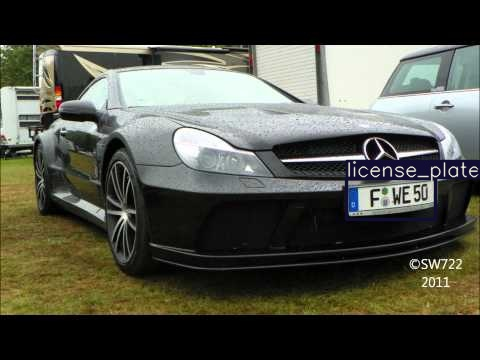

In [42]:
Image(DETECT_PATH+IMG_NAME+'.jpg')

In [45]:
pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
pip install --ignore-installed Pillow==9.0.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.0.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


390 198 89 41


AttributeError: ignored

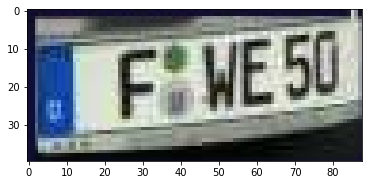

In [54]:
import pytesseract
import cv2
import matplotlib.pyplot as plt
from PIL import Image
img = cv2.imread(DETECT_PATH+IMG_NAME+'.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = img.resize((512,512),resample=Image.BICUBIC)
lics = read_txt(DETECT_PATH +'labels/'+IMG_NAME+'.txt')

for lic in lics:
    c, x, y, w, h = lic
    print(x,y,w,h) # center of the bounding box
    img_alpr = img[y-int(h/2):y+int(h/2),x-int(w/2):x+int(w/2)]
    plt.imshow(img_alpr)
    txt = pytesseract.image_to_string(img_alpr)
    print(txt)
    
#    img = cv2.putText(img, txt, (x-int(w/2),y-int(h/2)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)   
#cv2.imwrite('alpr_us1.jpg', img)